# Univariate Models: ARIMA, SARIMA, Prophet

## Data Preparation

### Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sktime.forecasting.all import temporal_train_test_split
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.simplefilter("ignore")

### Read data and create days to departure column

In [37]:
df = pd.read_csv('sample_data.csv')

In [38]:
df['day_to_dep'] = pd.to_datetime(df['flightDate']) - pd.to_datetime(df['searchDate'])
df['day_to_dep'].head()

0   1 days
1   1 days
2   1 days
3   1 days
4   1 days
Name: day_to_dep, dtype: timedelta64[ns]

### Get top 10 flights by flight count

In [39]:
# Group by startingAirport, destinationAirport, and flightDate, and count the number of flights
top_flights = df.groupby(['startingAirport', 'destinationAirport', 'flightDate']).size().reset_index(name='flight_count')

# Sort by flight_count in descending order and get the top 10
top_flights = top_flights.sort_values(by='flight_count', ascending=False).head(10)

print(top_flights)

      startingAirport destinationAirport  flightDate  flight_count
497               ATL                LAX  2022-04-26           269
12076             ORD                LAX  2022-04-19           264
493               ATL                LAX  2022-04-22           263
5920              EWR                LAX  2022-04-22           261
12079             ORD                LAX  2022-04-22           260
1107              BOS                DFW  2022-04-26           259
12687             PHL                DFW  2022-04-20           258
9522              LGA                ORD  2022-04-26           258
5070              DTW                LAX  2022-04-26           258
9335              LGA                LAX  2022-04-22           258


In [40]:
# Group the dataframe by departure airport, arrival airport, and departure date
grouped = df.groupby(['startingAirport', 'destinationAirport'])

# Extract unique flight identifiers
unique_flights = list(grouped.groups.keys())  # List of (start_airport, dest_airport) tuples

# Select 10 unique flights
selected_flights = unique_flights[:10]

# List to store DataFrames
flight_price_changes = []

# Iterate through selected flights
for flight in selected_flights:

    start_airport, dest_airport = flight
    
    # Get the corresponding DataFrame
    flight_df = grouped.get_group(flight).copy()
    
    # Sort by days to departure
    flight_df = flight_df.sort_values(by='day_to_dep')

    flight_price_changes.append(flight_df)

# Print the head of the first flight's dataframe
print('Flight 1:')
flight_price_changes[0].head()

Flight 1:


,Unnamed: 0,searchDate,flightDate,startingAirport,destinationAirport,travelDuration,isBasicEconomy,isRefundable,isNonStop,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeRaw,segmentsAirlineCode,segmentsCabinCode,day_to_dep
0,0,2022-04-16,2022-04-17,ATL,BOS,PT2H29M,False,False,True,248.60,9,947.0,2022-04-17T12:57:00.000-04:00,DL,coach,1 days
87691,87691,2022-04-17,2022-04-18,ATL,BOS,PT8H31M,False,False,False,277.58,0,NaN,2022-04-18T13:40:00.000-04:00||2022-04-18T18:5...,NK||NK,coach||coach,1 days
87692,87692,2022-04-17,2022-04-18,ATL,BOS,PT10H46M,True,False,False,282.19,9,947.0,2022-04-18T21:23:00.000-04:00||2022-04-19T07:0...,UA||UA,coach||coach,1 days
87693,87693,2022-04-17,2022-04-18,ATL,BOS,PT5H54M,False,False,False,290.58,0,NaN,2022-04-18T19:15:00.000-04:00||2022-04-18T22:0...,NK||NK,coach||coach,1 days
87694,87694,2022-04-17,2022-04-18,ATL,BOS,PT2H38M,False,False,True,300.10,7,947.0,2022-04-18T10:45:00.000-04:00,AA,coach,1 days


### Check totalFare NAs

In [41]:
# Print number of missing prices
missing_prices = pd.concat([flight_price_changes[i][flight_price_changes[i]['totalFare'].isnull()] for i in range(10)])
print("Number of missing prices in flights 1 to 10: " + str(len(missing_prices)))

Number of missing prices in flights 1 to 10: 0


In [29]:
# Perform mean fill for all flights
for i in range(10):
    flight_price_changes[i]['totalFare'] = flight_price_changes[i]['totalFare'].fillna(flight_price_changes[i]['totalFare'].mean())

# Print number of missing prices after mean filling
missing_prices = pd.concat([flight_price_changes[i][flight_price_changes[i]['totalFare'].isnull()] for i in range(10)])
print("Number of missing prices in flights 1 to 10: " + str(len(missing_prices)))

Number of missing prices in flights 1 to 10: 0


### Plot price changes for each flight leading up to departure date

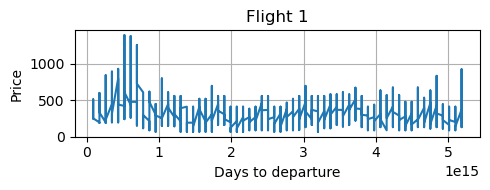

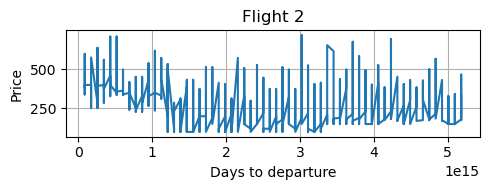

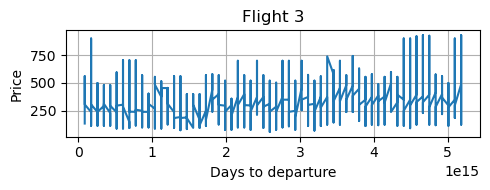

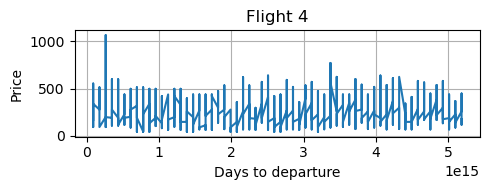

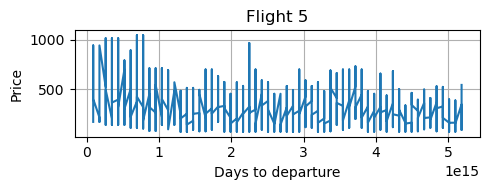

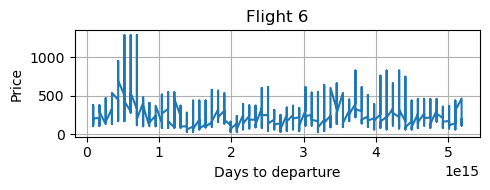

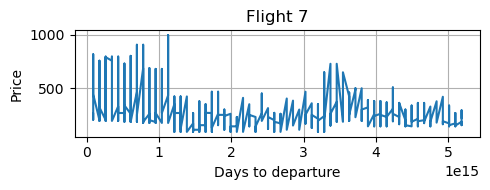

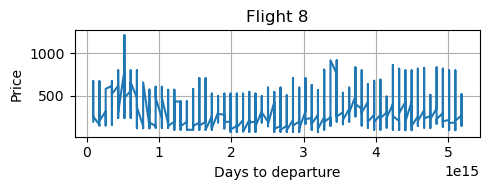

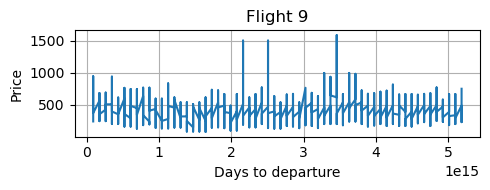

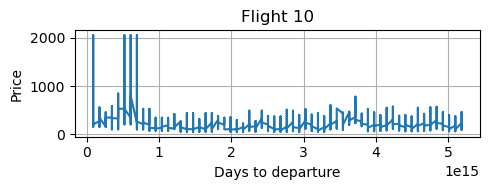

In [31]:
for i, flight_df in enumerate(flight_price_changes):
    plt.figure(figsize=(5,2))
    plt.plot(flight_df['day_to_dep'], flight_df['totalFare'])
    plt.title(f"Flight {i+1}")
    plt.xlabel('Days to departure')
    plt.ylabel('Price')
    plt.grid()
    plt.tight_layout()
    plt.show()

### Drop columns

In [49]:
# Define the columns to keep
columns_to_keep = ['startingAirport', 'destinationAirport', 'totalFare', 'day_to_dep', 'flightDate']

# Update each DataFrame in the flight_price_changes list
flight_price_changes = [df[columns_to_keep] for df in flight_price_changes]

# Print the head of the first flight's dataframe after dropping columns
print('Flight 1:')
flight_price_changes[0].head()

Flight 1:


,startingAirport,destinationAirport,totalFare,day_to_dep,flightDate
0,ATL,BOS,248.60,1 days,2022-04-17
87691,ATL,BOS,277.58,1 days,2022-04-18
87692,ATL,BOS,282.19,1 days,2022-04-18
87693,ATL,BOS,290.58,1 days,2022-04-18
87694,ATL,BOS,300.10,1 days,2022-04-18


### Create new dataframes to convert to a univariate time series

In [66]:
route_dataframes_original = []

for route in top_flights[['startingAirport', 'destinationAirport']].values:
    start_airport, dest_airport = route
    route_df = df[(df['startingAirport'] == start_airport) & (df['destinationAirport'] == dest_airport)][['day_to_dep', 'totalFare']]
    
    # Sorting by days to departure
    route_df = route_df.sort_values(by='day_to_dep')
    
    route_dataframes_original.append(route_df)

print("First Route DataFrame:")
route_dataframes_original[0].head()

First Route DataFrame:


,day_to_dep,totalFare
284,1 days,239.60
88021,1 days,578.60
88020,1 days,569.58
88019,1 days,563.61
88018,1 days,561.20


### Set day_to_dep as index and sort by day_to_dep

In [146]:
route_dataframes = []

for route_df in route_dataframes_original:
    route_df = route_df.set_index('day_to_dep')
    route_dataframes.append(route_df)

route_dataframes.sort(key=lambda x: x.shape[0], reverse=True)
route_dataframes[0].head()

,totalFare
day_to_dep,
1 days,253.1
1 days,447.6
1 days,447.6
1 days,447.6
1 days,447.6


### Create train and test sets

In [210]:
# Create a list that stores y_train and y_test sets
train_test = []

for route_df in route_dataframes:
    y_train, y_test = temporal_train_test_split(route_df)
    train_test.append((y_train, y_test)) # List of tuples for each route_df

## SARIMA Models

### Model fitting

In [168]:
# List to store SARIMA models
sarima_models = []

# Iterate over the 10 route DataFrames
for i, route_df in enumerate(route_dataframes):
        
    # Fitting the SARIMA model using auto_arima
    sarima_model = auto_arima(
                route_df['totalFare'],
                seasonal=True,
                m=7,
                suppress_warnings=True,
                error_action='ignore',
                trace=False,
                stepwise=True,
                maxiter=20,
                approximation=True,
                with_intercept='auto'
            )
    sarima_model = sarima_model.fit(route_df['totalFare'])

    # Store the model
    sarima_models.append(sarima_model)

    # Summary output
    print(f"SARIMA Model for Route {i+1}:")
    print(sarima_model.summary())
    print("\n")

SARIMA Model for Route 1:
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 7085
Model:             SARIMAX(1, 1, 2)x(0, 0, 2, 7)   Log Likelihood              -45334.979
Date:                           Wed, 12 Mar 2025   AIC                          90681.958
Time:                                   15:20:55   BIC                          90723.152
Sample:                                        0   HQIC                         90696.144
                                          - 7085                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8282      0.006    134.733      0.000       0.816       0.840
ma.L1         -1.

### Plot residuals

Route 1 Residuals:


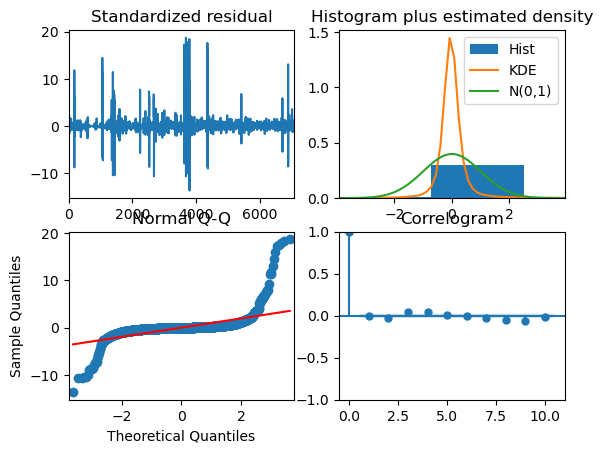

Route 2 Residuals:


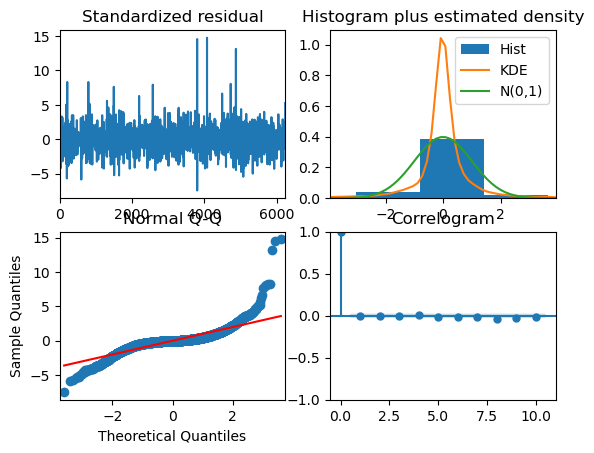

Route 3 Residuals:


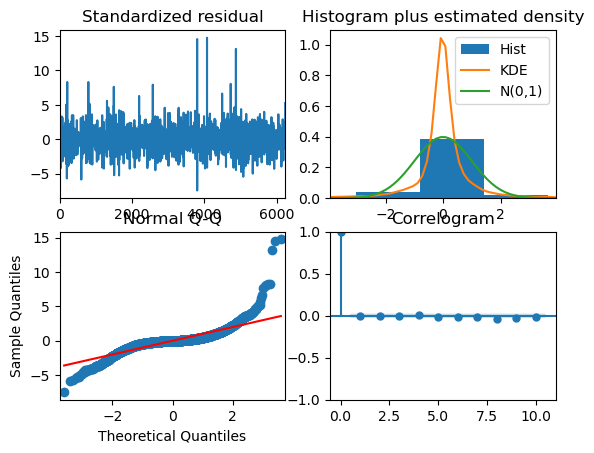

Route 4 Residuals:


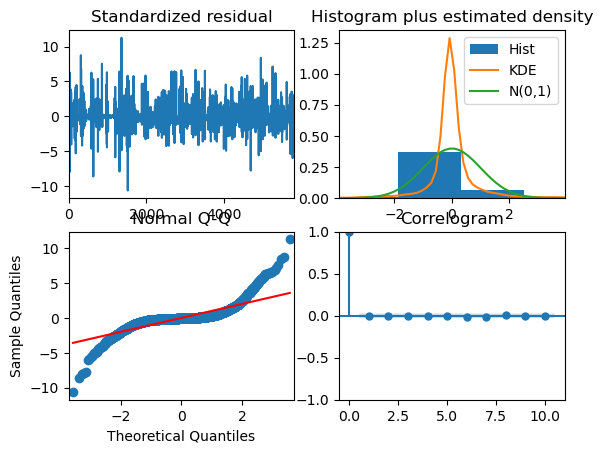

Route 5 Residuals:


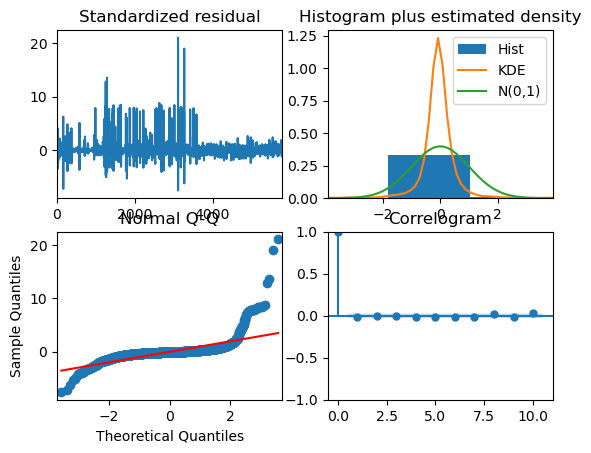

Route 6 Residuals:


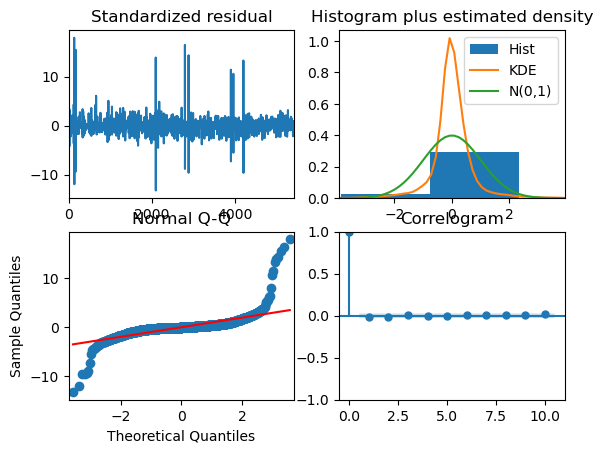

Route 7 Residuals:


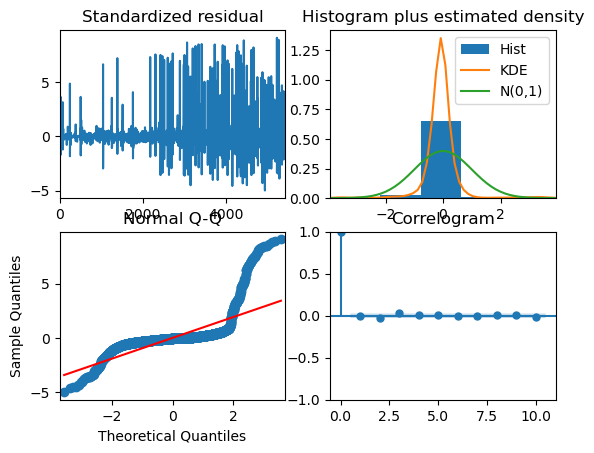

Route 8 Residuals:


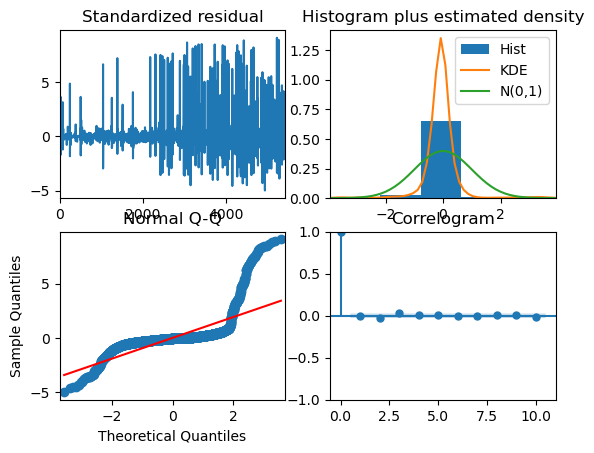

Route 9 Residuals:


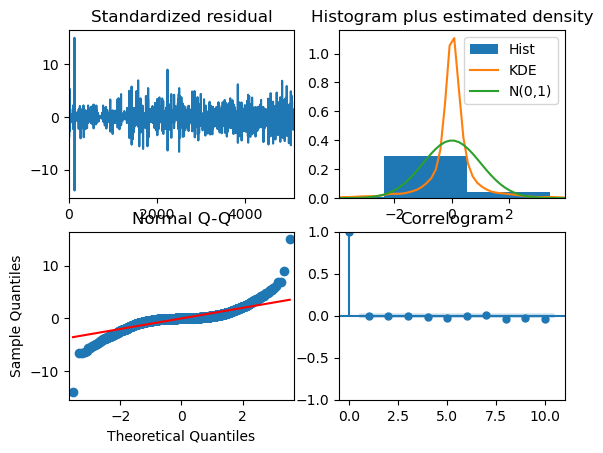

Route 10 Residuals:


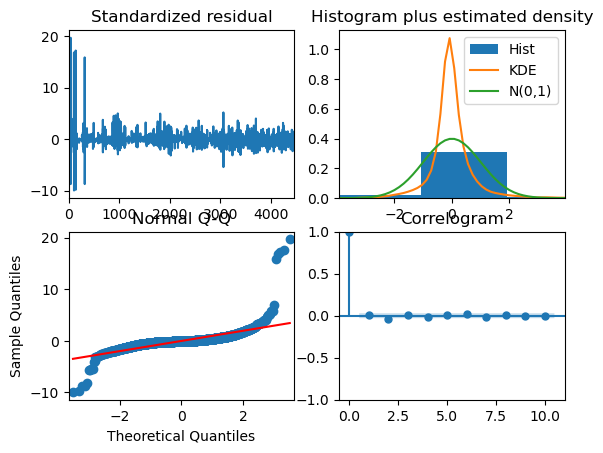

In [169]:
for i, model in enumerate(sarima_models):
    print(f'Route {i+1} Residuals:')
    model.plot_diagnostics()
    plt.show()

## ARIMA Models

### Model fitting

In [110]:
# List to store ARIMA models
arima_models = []

# Index iterator
i = 0

# Iterate over each route DataFrame
for route_df, y in zip(route_dataframes, train_test):

    # Training set is first series in tuple
    y_train = y[0]
        
    # Fitting the ARIMA model using auto_arima
    arima_model = auto_arima(
                y_train,
                seasonal=False,
                suppress_warnings=True,
                error_action='ignore',
                trace=False,
                stepwise=True,
                maxiter=30,
                approximation=True,
                with_intercept='auto'
            )
    arima_model = arima_model.fit(y_train)

    # Store the model
    arima_models.append(arima_model)

    # Print Summary
    print(f"SARIMA Model for Route {i+1}:")
    print(arima_model.summary())
    print("\n")

    i += 1

SARIMA Model for Route 1:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5313
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -34581.956
Date:                Wed, 12 Mar 2025   AIC                          69169.912
Time:                        13:39:14   BIC                          69189.645
Sample:                             0   HQIC                         69176.807
                               - 5313                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7225      0.003    207.587      0.000       0.716       0.729
ma.L1         -0.9897      0.001   -713.879      0.000      -0.992      -0.987
sigma2      2.642e+04     

### Plot residuals

Route 1 Residuals:


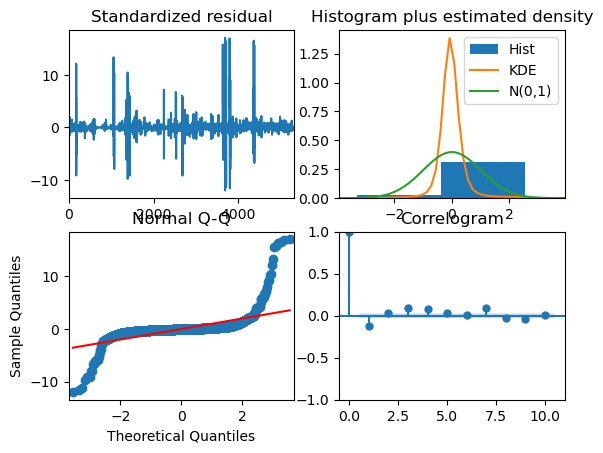

Route 2 Residuals:


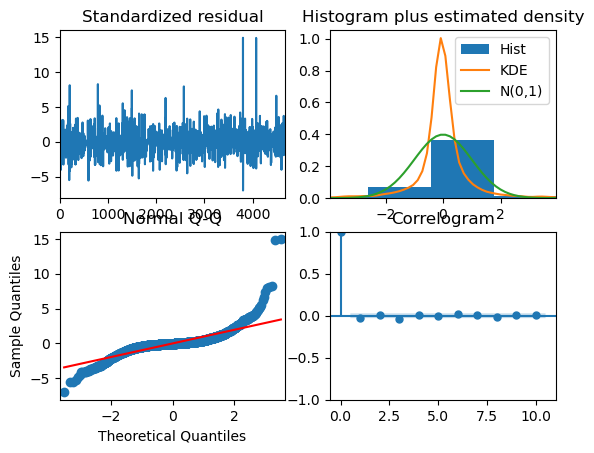

Route 3 Residuals:


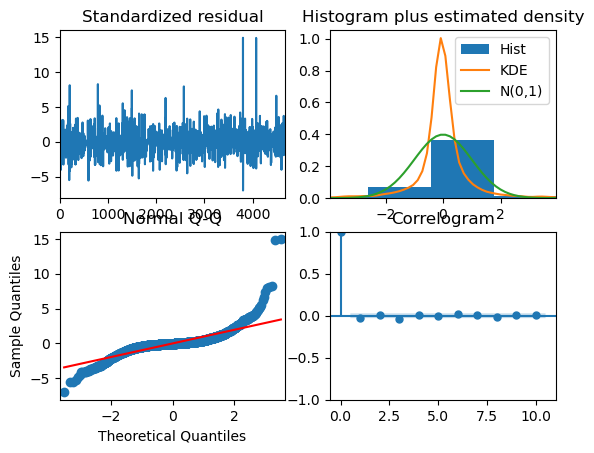

Route 4 Residuals:


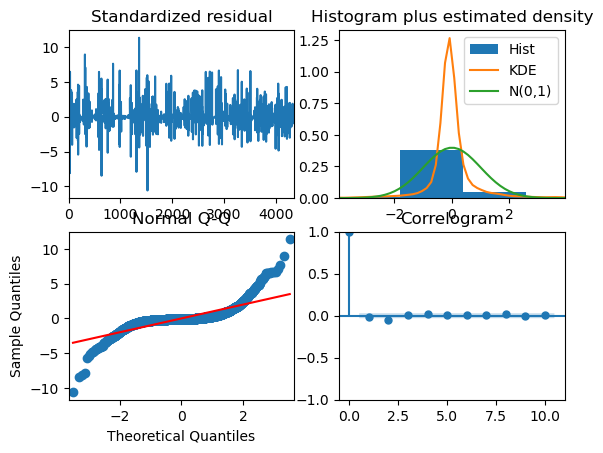

Route 5 Residuals:


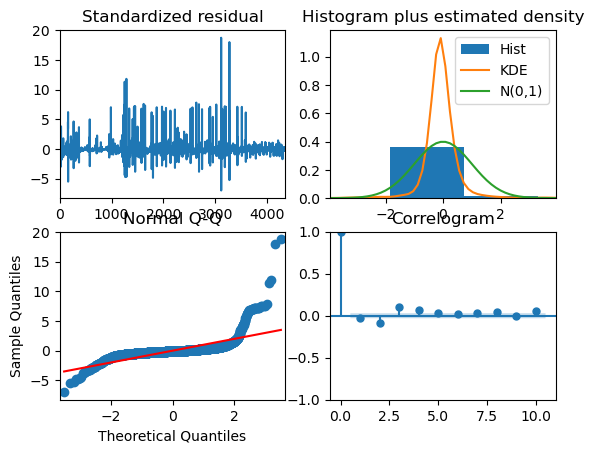

Route 6 Residuals:


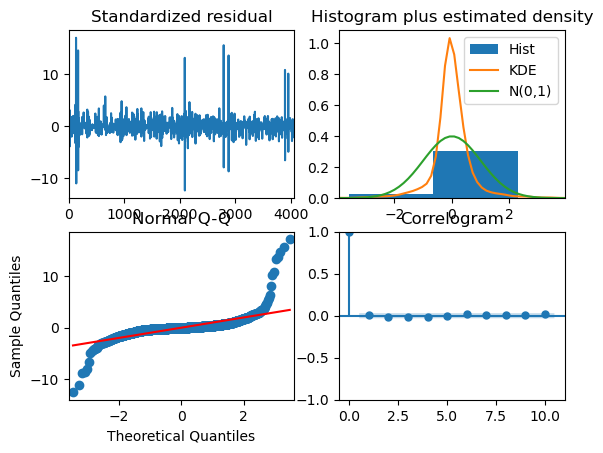

Route 7 Residuals:


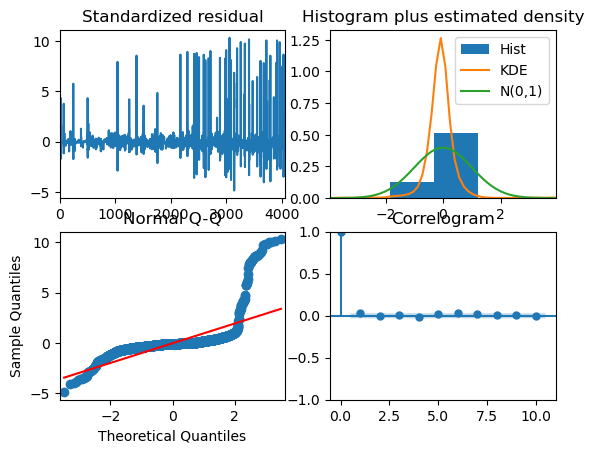

Route 8 Residuals:


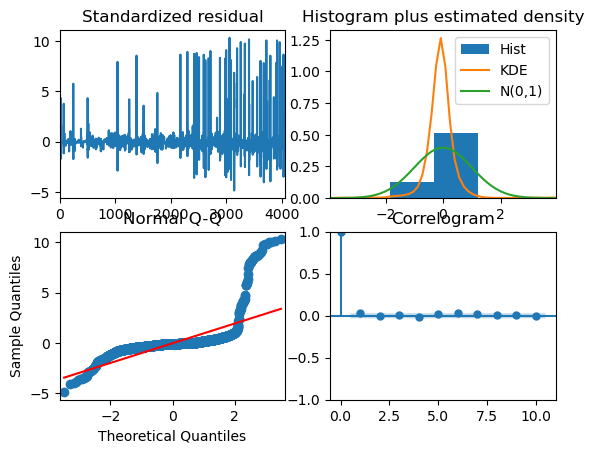

Route 9 Residuals:


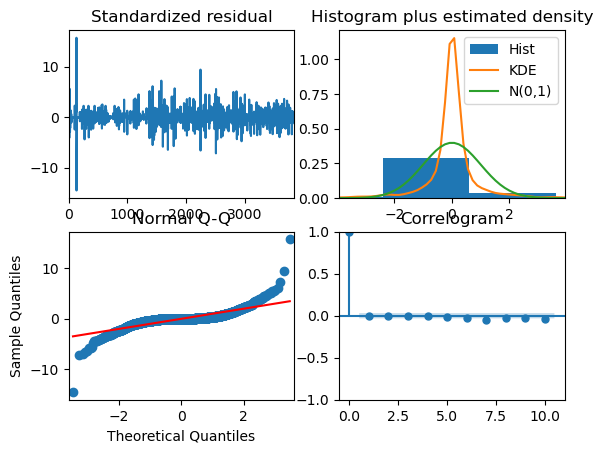

Route 10 Residuals:


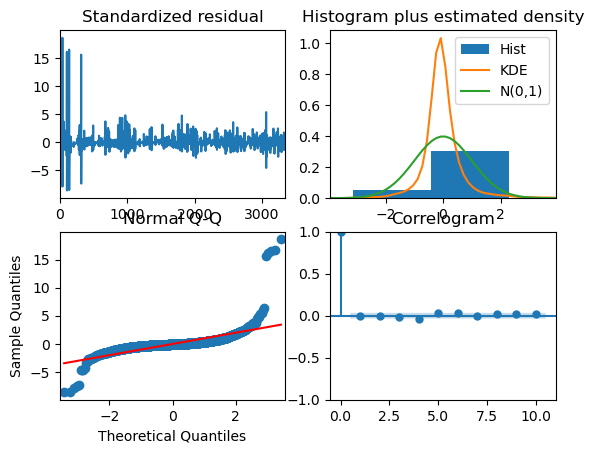

In [111]:
for i, model in enumerate(arima_models):
    print(f'Route {i+1} Residuals:')
    model.plot_diagnostics()
    plt.show()

## Prophet Models

### Model fitting

In [154]:
# List to store Prophet models
prophet_models = []

# Iterate over each route DataFrame and corresponding training data
for i, (route_df, y) in enumerate(zip(route_dataframes, train_test)):
    
    y_train = y[0]

    # Prepare the DataFrame for Prophet using training data
    train_df = route_df.loc[y_train.index].reset_index()[['day_to_dep', 'totalFare']]
    train_df.columns = ['ds', 'y']
    start_date = pd.Timestamp("2022-06-01")
    train_df['ds'] = start_date + train_df['ds']

    # Fit the Prophet model
    model = Prophet()
    model.fit(train_df)

    # Store the model
    prophet_models.append(model)

    # Print Summary
    print(f"Prophet Model for Route {i+1} fitted.")

14:39:59 - cmdstanpy - INFO - Chain [1] start processing
14:41:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model for Route 1 fitted.


14:42:06 - cmdstanpy - INFO - Chain [1] start processing
14:45:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model for Route 2 fitted.


14:45:35 - cmdstanpy - INFO - Chain [1] start processing
14:49:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model for Route 3 fitted.


14:49:28 - cmdstanpy - INFO - Chain [1] start processing
14:54:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model for Route 4 fitted.


14:54:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model for Route 5 fitted.


14:57:26 - cmdstanpy - INFO - Chain [1] start processing
14:59:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model for Route 6 fitted.


14:59:27 - cmdstanpy - INFO - Chain [1] start processing
15:01:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model for Route 7 fitted.


15:01:14 - cmdstanpy - INFO - Chain [1] start processing
15:02:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model for Route 8 fitted.


15:03:06 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model for Route 9 fitted.


15:04:52 - cmdstanpy - INFO - Chain [1] start processing
15:07:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model for Route 10 fitted.


### Forecast and plot

<Figure size 200x200 with 0 Axes>

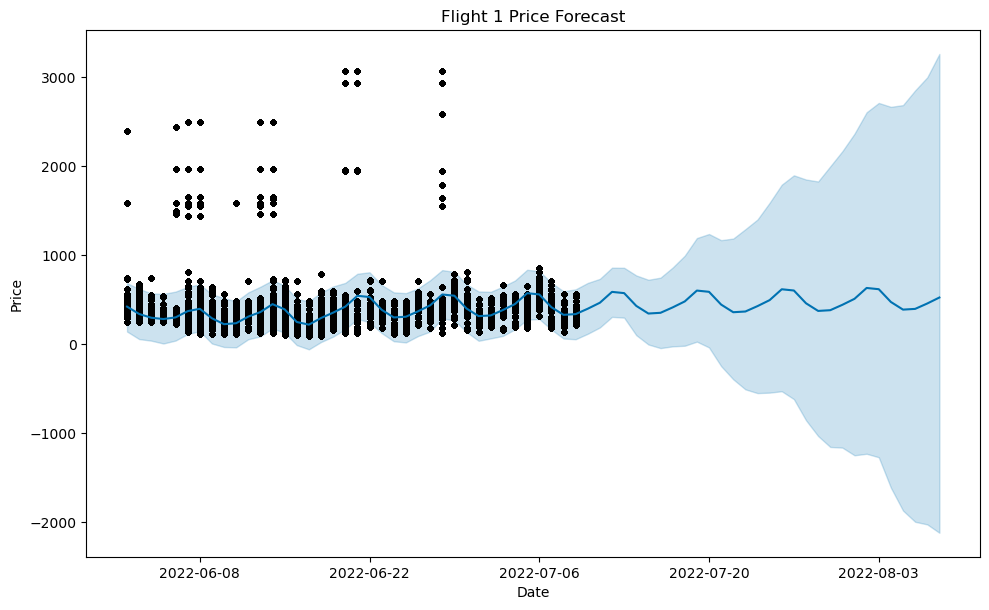

<Figure size 200x200 with 0 Axes>

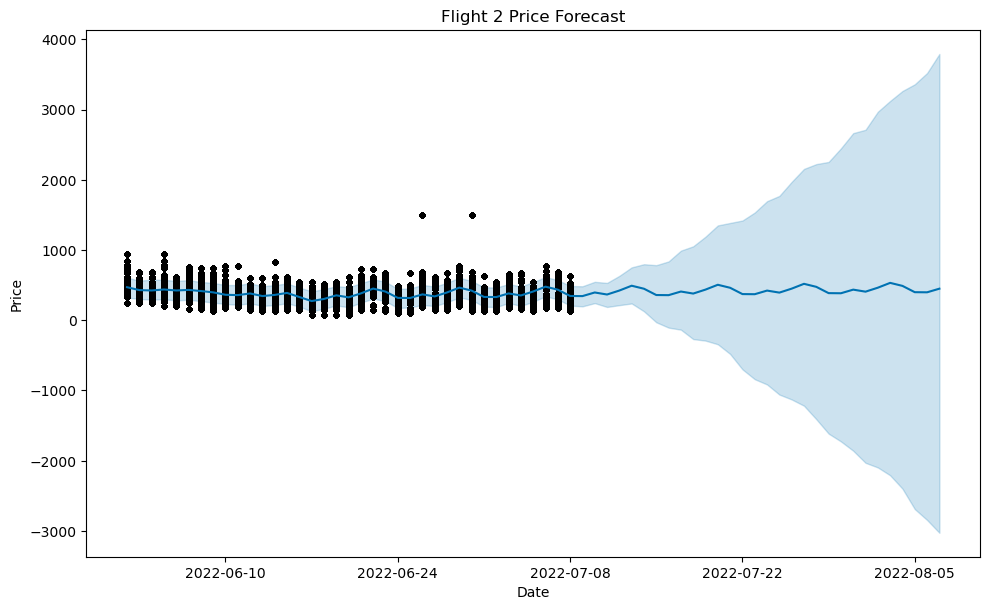

<Figure size 200x200 with 0 Axes>

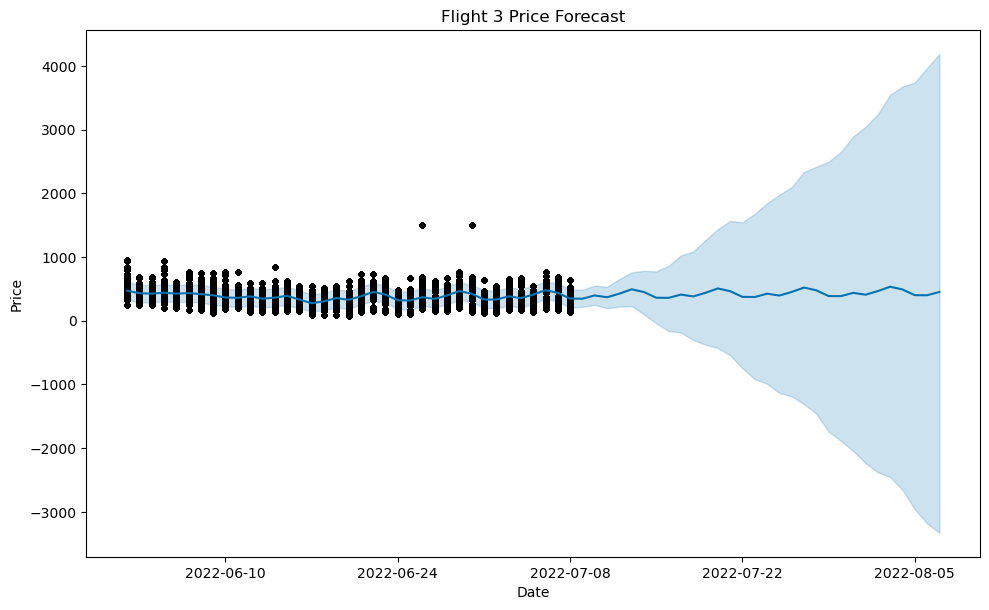

<Figure size 200x200 with 0 Axes>

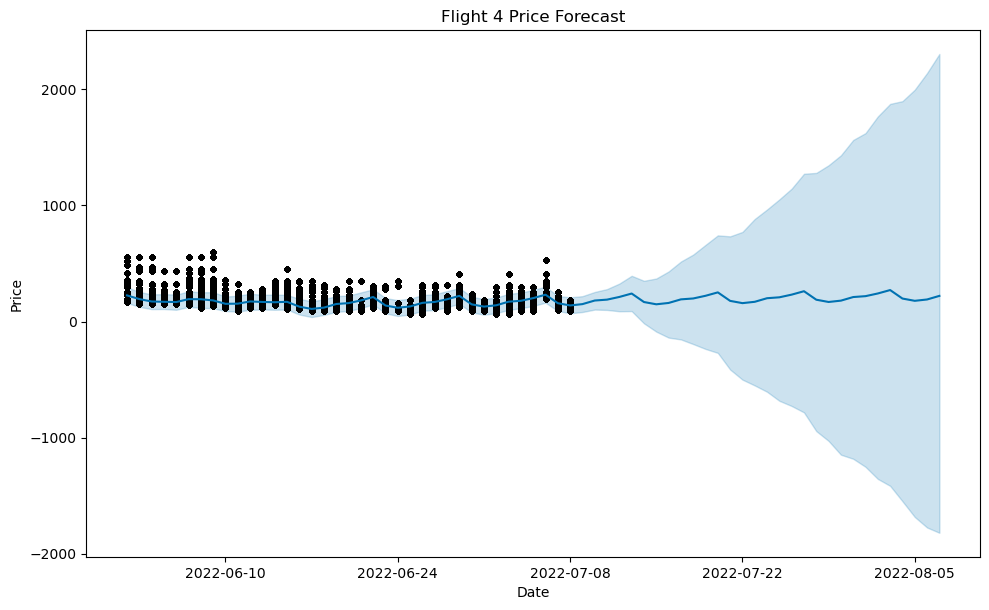

<Figure size 200x200 with 0 Axes>

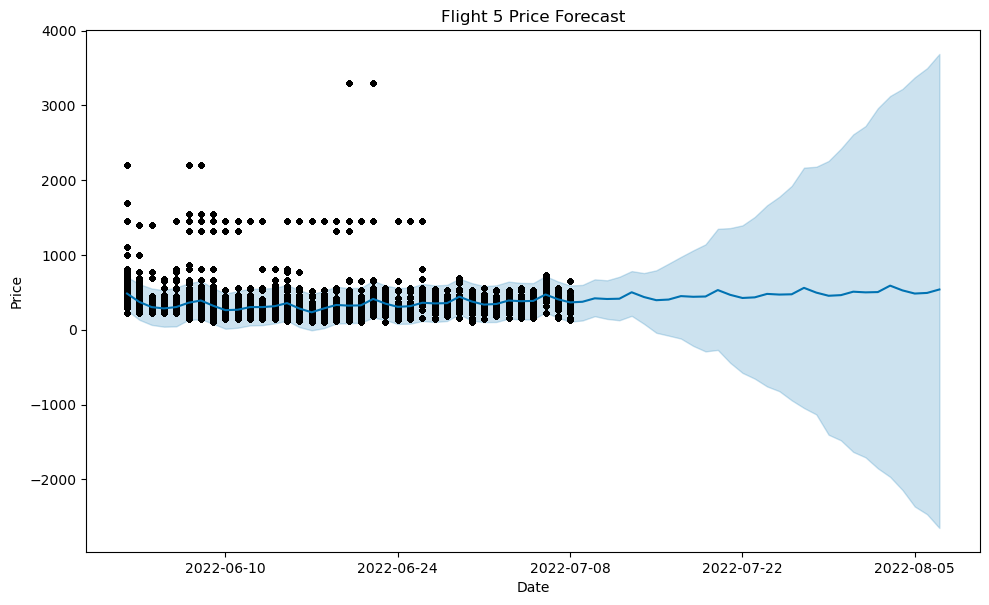

<Figure size 200x200 with 0 Axes>

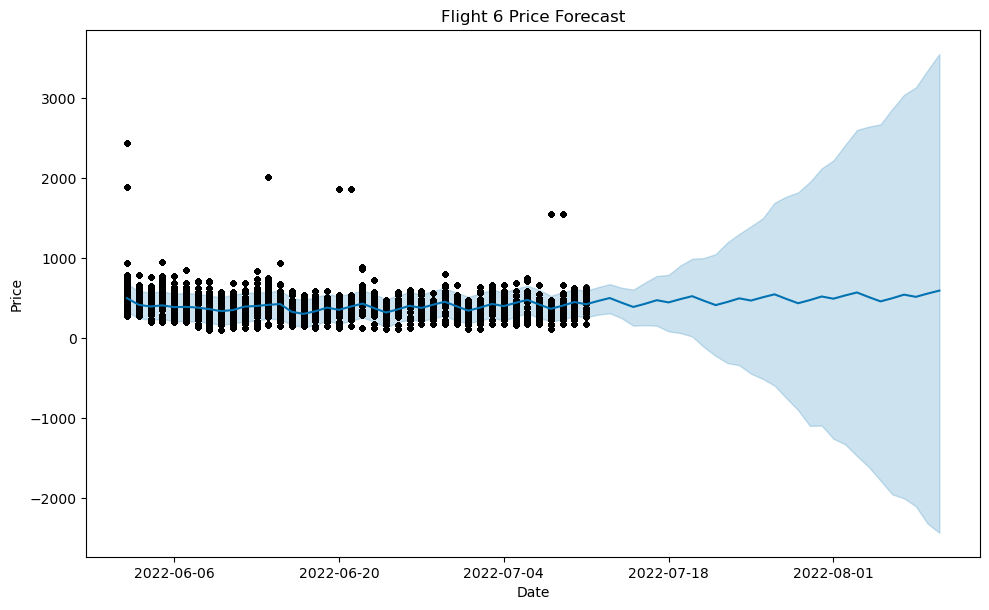

<Figure size 200x200 with 0 Axes>

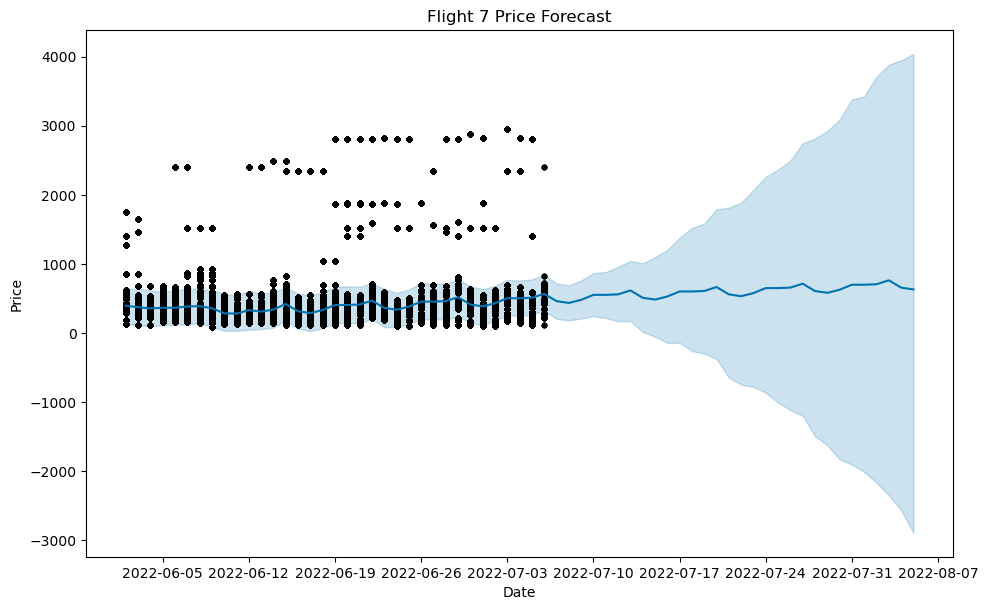

<Figure size 200x200 with 0 Axes>

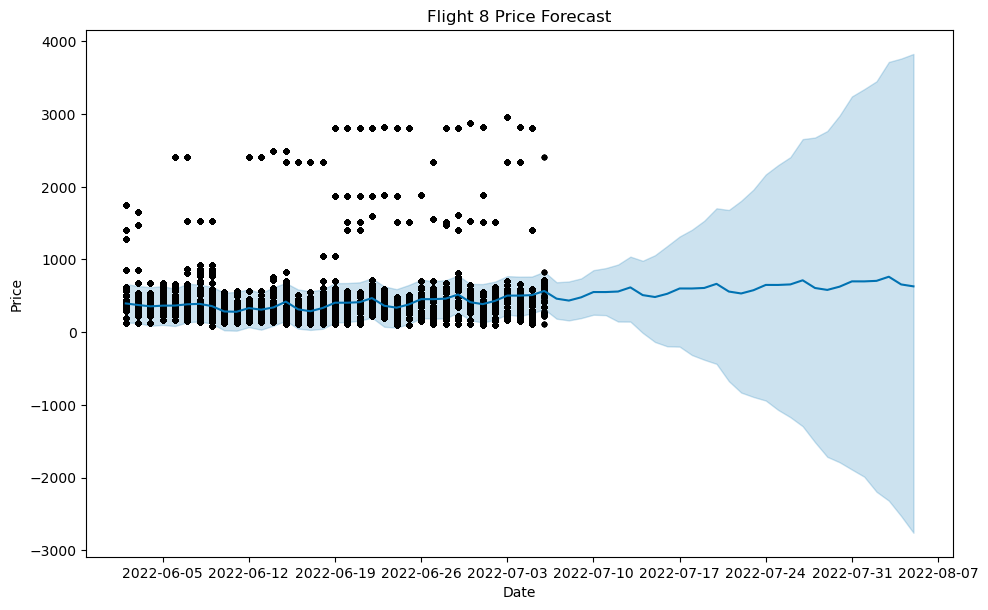

<Figure size 200x200 with 0 Axes>

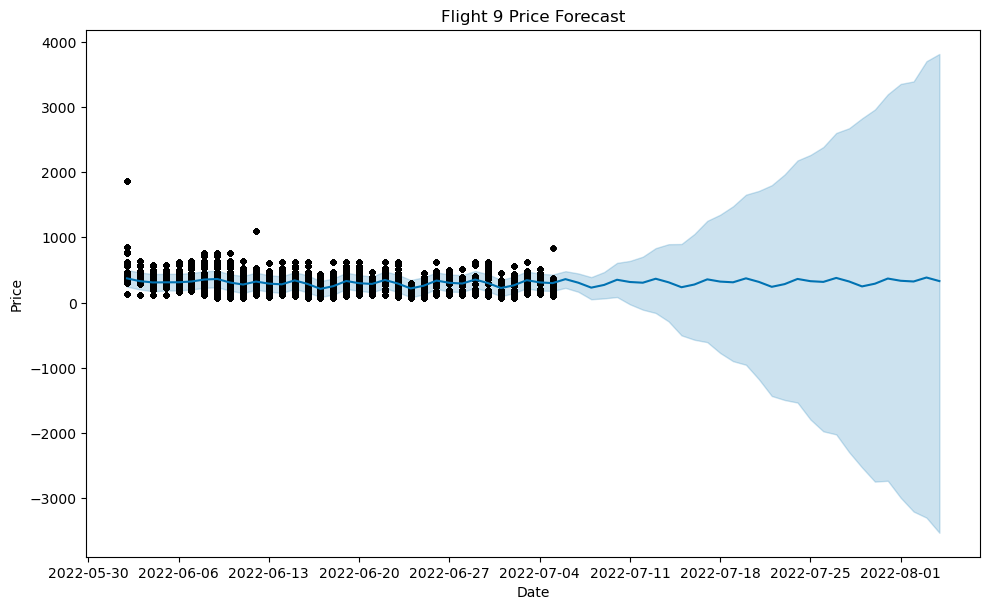

<Figure size 200x200 with 0 Axes>

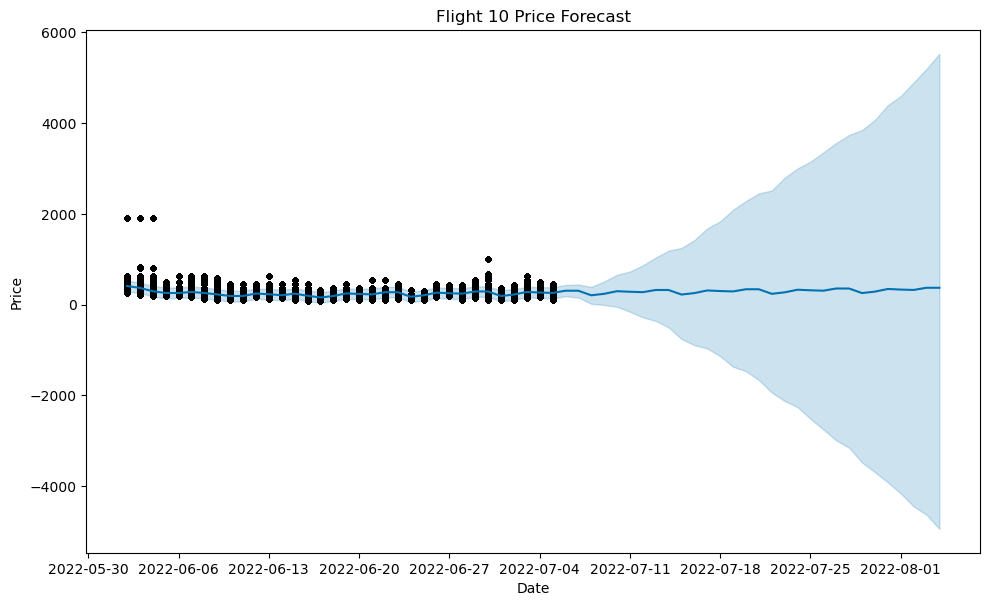

In [157]:
# Forcast the price for every flight
for i, model in enumerate(prophet_models):
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    model.plot(forecast)
    plt.title(f"Flight {i+1} Price Forecast")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid()
    plt.show()

## Error Metric Evaluation

### Calculate MAE, MSE, RMSE, MAP, R², and the average across all models

In [195]:
def error_metrics(models, train_test, prophet=False):
    metrics_list = []
    i = 0
    
    for model, y in zip(models, train_test):
        y_train = y[0]
        y_test = y[1]

        if prophet:
            # Get forecast for Prophet models
            y_test_prophet = y_test
            start_date = pd.Timestamp("2022-06-01")
            y_test_prophet.columns = ['y']
            y_test_prophet['ds'] = start_date + y_test_prophet.index

            future_data = pd.DataFrame(y_test_prophet['ds'])
            forecast = model.predict(future_data)
            y_pred = forecast['yhat']

            # Calculate metrics
            mae = mean_absolute_error(y_test_prophet, y_pred)
            mse = mean_squared_error(y_test_prophet, y_pred)
            rmse = np.sqrt(mse)
            mape = mean_absolute_percentage_error(y_test_prophet, y_pred)
            r2 = r2_score(y_test_prophet, y_pred)

        else:
            # Get forecast for ARIMA / SARIMA models
            y_pred = model.predict(n_periods=len(y_test))

            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mape = mean_absolute_percentage_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
        
        
        metrics_list.append({
            'Model': f'Model_{i+1}',
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        i += 1
    
    # Create DataFrame of all metrics
    metrics_df = pd.DataFrame(metrics_list)
    
    # Calculate average metrics
    avg_metrics = metrics_df.mean(numeric_only=True)
    
    print(metrics_df)
    print('\nAverages:')
    print(avg_metrics)

### Compare model results

In [211]:
print('SARIMA Error Metrics:')
error_metrics(sarima_models, train_test)

print('\nARIMA Error Metrics:')
error_metrics(arima_models, train_test)

SARIMA Error Metrics:
      Model         MAE            MSE        RMSE      MAPE        R²
0   Model_1  100.316730   21779.093255  147.577414  0.263741 -0.002188
1   Model_2  202.099628   53668.764625  231.665199  0.650562 -1.662485
2   Model_3  202.099628   53668.764625  231.665199  0.650562 -1.662485
3   Model_4   62.036559    6664.489839   81.636327  0.347075 -0.146672
4   Model_5  123.260568   20820.686345  144.293750  0.409950 -0.420136
5   Model_6   96.478442   15605.403269  124.921588  0.265019 -0.018482
6   Model_7  207.988174  181028.651625  425.474619  0.461163 -0.016025
7   Model_8  207.988174  181028.651625  425.474619  0.461163 -0.016025
8   Model_9  108.258978   19802.929498  140.722882  0.389452 -0.009380
9  Model_10  121.488309   21032.652426  145.026385  0.549459 -0.900437

Averages:
MAE       143.201519
MSE     57510.008713
RMSE      209.845798
MAPE        0.444815
R²         -0.485432
dtype: float64

ARIMA Error Metrics:
      Model         MAE            MSE      

Comparing the error metrics between SARIMA and ARIMA models, we can observe that ARIMA generally performs better across most metrics. ARIMA has a lower average MAE (135.48 vs 143.20), MSE (51646.80 vs 57510.01), RMSE (193.22 vs 209.85), and MAPE (0.4174 vs 0.4448), indicating better overall accuracy and lower prediction errors. The R² values for both models are negative, suggesting poor fit, but ARIMA's average R² (-0.1358) is less negative than SARIMA's (-0.4854), indicating a relatively better fit.

The flight price forecast visuals for Prophet, which display actual prices as black dots and predicted prices with confidence intervals as a blue line and shaded area, show a common trend of unrealistically sharp price decreases into negative territory by August, despite fitting well to the initial historical data. While the model seems to capture the short-term variations and outlier price points show reasonable confidence intervals widening as predictions extend into the future, the negative price predictions reveal a flaw in the model's ability to generalize beyond the existing data, pointing to potential issues in model configuration, data preprocessing, or unrealistic assumptions.